Unique words in corpus: 18760
Unique tags in corpus: 17
Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


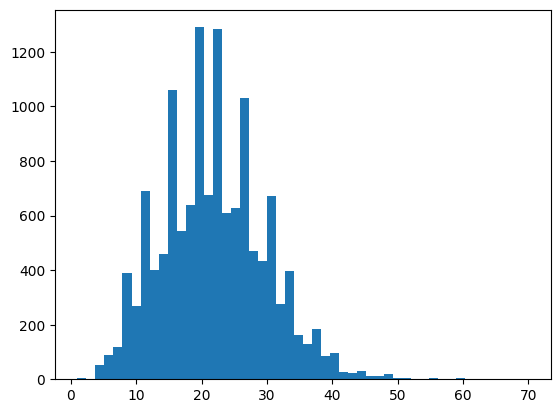

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            938050    
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

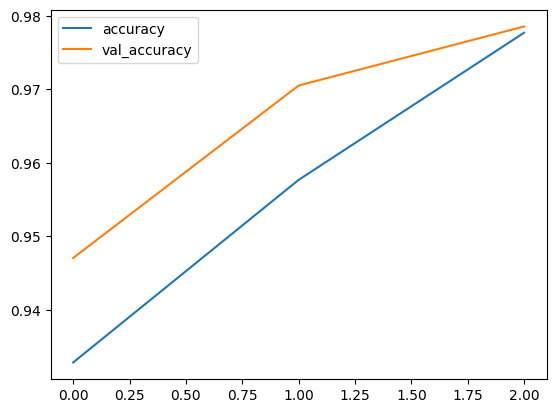

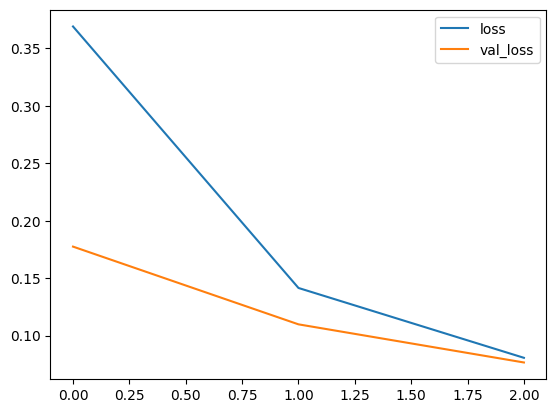

In [ ]:


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model
data = pd.read_csv("ner_dataset - ner_dataset.csv", encoding="latin1")
data.head(50)
data = data.fillna(method="ffill")
data.head(50)
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())
words=list(data['Word'].unique())
words.append("ENDPAD")
tags=list(data['Tag'].unique())
print("Unique tags are:", tags)
num_words = len(words)
num_tags = len(tags)
num_words
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
getter = SentenceGetter(data)
sentences = getter.sentences
len(sentences)
sentences[0]
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
word2idx
plt.hist([len(s) for s in sentences], bins=50)
plt.show()
X1 = [[word2idx[w[0]] for w in s] for s in sentences]
type(X1[0])
X1[0]
max_len = 50
nums = [[1], [2, 3], [4, 5, 6]]
sequence.pad_sequences(nums)
nums = [[1], [2, 3], [4, 5, 6]]
sequence.pad_sequences(nums,maxlen=2)
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)
X[0]
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train[0]
y_train[0]

input_word = layers.Input(shape=(max_len,))
embedding_layer=layers.Embedding(input_dim=num_words,output_dim=50,input_length=max_len)(input_word)
dropout_layer=layers.SpatialDropout1D(0.1)(embedding_layer)
bidirectional_lstm=layers.Bidirectional(layers.LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(dropout_layer)
output=layers.TimeDistributed(layers.Dense(num_tags,activation="softmax"))(bidirectional_lstm)
model = Model(input_word, output)

model.summary()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=32,
    epochs=3,
)

metrics = pd.DataFrame(model.history.history)
metrics.head()
metrics[['accuracy','val_accuracy']].plot()
metrics[['loss','val_loss']].plot()
i = 20
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))
